# **Ethereum Price Forecasting**

# **PROBLEM DESCRIPTION**

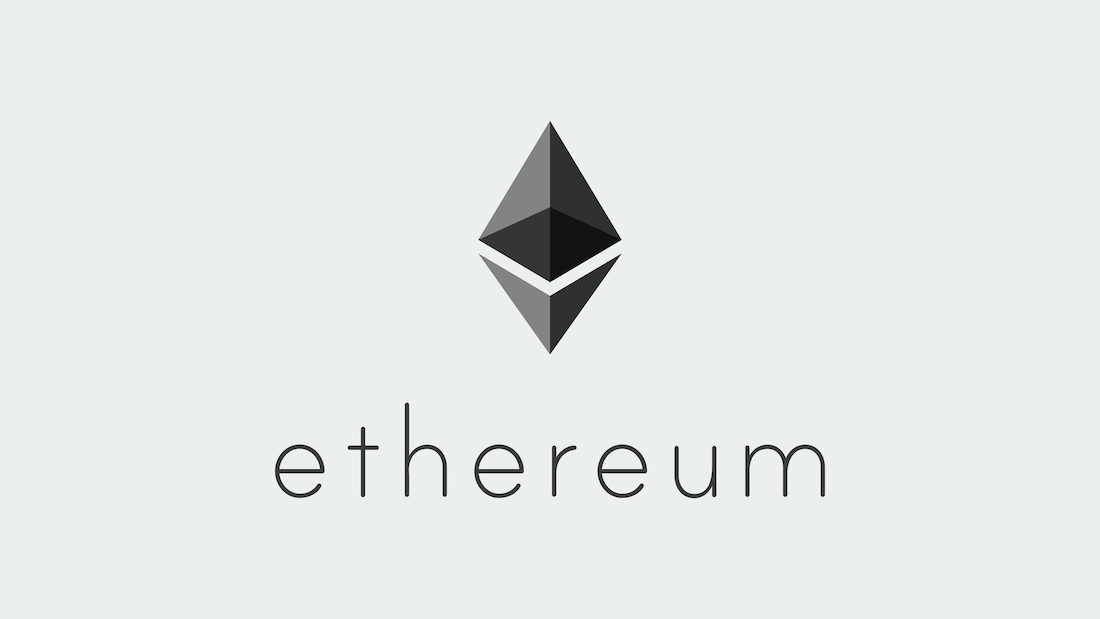

Cryptocurrencies have become one of the most discussed internet talking points in recent years. Twitter's CEO Jack Dorsey calls them "Internet money" and believes it will be with us forever. Elon Musk of Tesla tweets about Cryptocurrencies (especially "Dogecoin") almost every week. As of January 2022, there are more than 6000 cryptocurrencies in the market - an extreme growth from just a handful of digital coins in 2013. 
It is believed that the top 20 cryptocurrencies make up nearly 90 percent of the total market. Ethereum or ETH is one of them. While ETH price increased exponentially since its creation, daily or even hourly fluctuation is part of the game. Some people get rich, and some people get broke. While various factors can influence the ETH price on the market, Ethereum price forecasting can be seen as a time-series problem. In this project, I will try to deploy different machine learning models to predict ETH price and validate it on recent data.

#**1 Data Loading**

##**1.1 Loading Libraries**

In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import *

from sklearn.metrics import  mean_absolute_error, r2_score 
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

import xgboost
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu

plt.style.use('seaborn-darkgrid')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##**1.2 Loading Dataset**

In [2]:
df = pd.read_csv('/content/Binance_ETHUSDT_1h.csv')
df.head(5)

,,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
1642204800000,2022-01-15 00:00:00,ETH/USDT,3307.42000000,3325.68000000,3307.22000000,3311.03000000,3469.70920000,11504499.77692300,6384
1642201200000,2022-01-14 23:00:00,ETH/USDT,3313.49000000,3318.70000000,3293.13000000,3307.42000000,7636.26280000,25256207.62510300,16766
1642197600000,2022-01-14 22:00:00,ETH/USDT,3331.04000000,3332.69000000,3313.22000000,3313.49000000,6819.06350000,22662502.90095700,15593
1642194000000,2022-01-14 21:00:00,ETH/USDT,3303.18000000,3342.79000000,3302.02000000,3331.04000000,8602.00150000,28544497.51033000,22264


In [3]:
df.columns

Index(['https://www.CryptoDataDownload.com'], dtype='object')

In [4]:
df.shape

(41313, 1)

#**2 Analysis Plan**

#**3 Data Preprocessing**

DATA FORMATTING

In [5]:
df = pd.read_csv('/content/Binance_ETHUSDT_1h.csv', header=1)
df.tail()

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
41307,1.502957e+09,2017-08-17 08-AM,ETH/USDT,307.96,309.97,307.0,308.62,150.75,46559.46,NaN
41308,1.502953e+09,2017-08-17 07-AM,ETH/USDT,302.68,307.96,302.6,307.96,753.19,229248.31,NaN
41309,1.502950e+09,2017-08-17 06-AM,ETH/USDT,303.10,304.44,301.9,302.68,302.51,91622.68,NaN
41310,1.502946e+09,2017-08-17 05-AM,ETH/USDT,301.61,303.28,300.0,303.10,377.67,114043.28,NaN
41311,1.502942e+09,2017-08-17 04-AM,ETH/USDT,652.74,652.74,298.0,300.79,122.52,36736.84,NaN


In [6]:
df.columns

Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume ETH',
       'Volume USDT', 'tradecount'],
      dtype='object')

In [7]:
df.shape

(41312, 10)

In [8]:
nan_data = df[df.date.str.len() < 19]
nan_data.shape

(28584, 10)

In [9]:
nan_data.head()

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
10080,1.605856e+09,2020-11-20 07-AM,ETH/USDT,484.36,493.98,483.52,488.78,110208.60,53992827.61,NaN
10082,1.605852e+09,2020-11-20 06-AM,ETH/USDT,484.80,485.43,481.50,484.36,33139.36,16021860.93,NaN
10084,1.605848e+09,2020-11-20 05-AM,ETH/USDT,486.15,486.75,482.00,484.80,35289.80,17090833.07,NaN
10086,1.605845e+09,2020-11-20 04-AM,ETH/USDT,484.86,488.07,484.81,486.15,43561.07,21182688.59,NaN
10088,1.605841e+09,2020-11-20 03-AM,ETH/USDT,481.92,487.75,481.92,484.86,68406.45,33200073.03,NaN


In [10]:
eth_data = df[df.date.str.len() >= 19]
eth_data.shape

(12728, 10)

In [11]:
nan_data['date'] = nan_data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %I-%p'))
nan_data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
10080,1.605856e+09,2020-11-20 07:00:00,ETH/USDT,484.36,493.98,483.52,488.78,110208.60,53992827.61,NaN
10082,1.605852e+09,2020-11-20 06:00:00,ETH/USDT,484.80,485.43,481.50,484.36,33139.36,16021860.93,NaN
10084,1.605848e+09,2020-11-20 05:00:00,ETH/USDT,486.15,486.75,482.00,484.80,35289.80,17090833.07,NaN
10086,1.605845e+09,2020-11-20 04:00:00,ETH/USDT,484.86,488.07,484.81,486.15,43561.07,21182688.59,NaN
10088,1.605841e+09,2020-11-20 03:00:00,ETH/USDT,481.92,487.75,481.92,484.86,68406.45,33200073.03,NaN
10090,1.605838e+09,2020-11-20 02:00:00,ETH/USDT,479.39,483.95,478.38,481.92,60724.18,29231949.82,NaN
10092,1.605834e+09,2020-11-20 01:00:00,ETH/USDT,471.47,479.50,470.65,479.39,32178.21,15308935.48,NaN
10094,1.605830e+09,2020-11-20 00:00:00,ETH/USDT,471.25,473.70,470.81,471.47,22371.70,10569354.93,NaN
10096,1.605827e+09,2020-11-19 23:00:00,ETH/USDT,471.85,473.09,468.63,471.25,26549.90,12483656.60,NaN
10098,1.605823e+09,2020-11-19 22:00:00,ETH/USDT,472.47,473.49,471.00,471.85,10808.02,5106620.97,NaN


In [12]:
eth = pd.concat([eth_data, nan_data], axis=0)
eth.shape

(41312, 10)

In [13]:
eth.tail(3)

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount
41309,1.502950e+09,2017-08-17 06:00:00,ETH/USDT,303.10,304.44,301.9,302.68,302.51,91622.68,NaN
41310,1.502946e+09,2017-08-17 05:00:00,ETH/USDT,301.61,303.28,300.0,303.10,377.67,114043.28,NaN
41311,1.502942e+09,2017-08-17 04:00:00,ETH/USDT,652.74,652.74,298.0,300.79,122.52,36736.84,NaN


In [14]:
# eth.to_csv('eth.csv')

In [15]:
eth['date'] = pd.to_datetime(eth.date)
eth.set_index('date', inplace=True)
eth.drop(columns=['unix','symbol', 'tradecount'], inplace=True)
eth.sort_index(ascending=True, inplace=True)
eth.head()

,open,high,low,close,Volume ETH,Volume USDT
date,,,,,,
2017-08-17 04:00:00,652.74,652.74,298.0,300.79,122.52,36736.84
2017-08-17 05:00:00,301.61,303.28,300.0,303.10,377.67,114043.28
2017-08-17 06:00:00,303.10,304.44,301.9,302.68,302.51,91622.68
2017-08-17 07:00:00,302.68,307.96,302.6,307.96,753.19,229248.31
2017-08-17 08:00:00,307.96,309.97,307.0,308.62,150.75,46559.46


In [16]:
eth.isnull().sum()

open           0
high           0
low            0
close          0
Volume ETH     0
Volume USDT    1
dtype: int64

In [17]:
nan = eth[eth.isnull().any(axis=1)]
nan

,open,high,low,close,Volume ETH,Volume USDT
date,,,,,,
2019-11-07 03:00:00,189.41,189.82,188.81,189.43,6747.07,NaN


In [18]:
rows_toavg = eth.loc[['2019-11-07 02:00:00','2019-11-07 04:00:00'], 'Volume USDT']
rows_toavg

date
2019-11-07 02:00:00    3646084.64
2019-11-07 04:00:00    1640634.99
Name: Volume USDT, dtype: float64

In [19]:
eth.fillna(rows_toavg.mean(), inplace=True)

In [20]:
eth.isnull().sum()

open           0
high           0
low            0
close          0
Volume ETH     0
Volume USDT    0
dtype: int64

In [21]:
eth.loc['2019-11-07 02:00:00':'2019-11-07 05:00:00']

,open,high,low,close,Volume ETH,Volume USDT
date,,,,,,
2019-11-07 02:00:00,189.72,189.82,188.39,189.41,19281.54,3646084.640
2019-11-07 03:00:00,189.41,189.82,188.81,189.43,6747.07,2643359.815
2019-11-07 04:00:00,189.43,189.76,189.00,189.05,8664.56,1640634.990
2019-11-07 05:00:00,189.05,189.78,187.19,189.68,24101.13,4542629.970


#**4 Data Description and Exploration**

##**4.1 Data Information**

In [ ]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41312 entries, 2017-08-17 04:00:00 to 2022-01-15 00:00:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         41312 non-null  float64
 1   high         41312 non-null  float64
 2   low          41312 non-null  float64
 3   close        41312 non-null  float64
 4   Volume ETH   41312 non-null  float64
 5   Volume USDT  41312 non-null  float64
dtypes: float64(6)
memory usage: 3.5 MB


##**4.2 Summary Statistics**

In [ ]:
eth.describe()

,open,high,low,close,Volume ETH,Volume USDT
count,41312.000000,41312.000000,41312.000000,41312.000000,41312.000000,4.131200e+04
mean,875.731748,882.311587,868.569548,875.798281,23279.168971,2.384489e+07
std,1140.529335,1148.349999,1132.027757,1140.590697,28588.760355,4.934894e+07
min,82.170000,82.950000,81.790000,82.170000,0.000000,0.000000e+00
25%,204.067500,204.987500,202.857500,204.067500,6424.015000,1.724154e+06
50%,362.300000,364.460000,359.300000,362.305000,15037.628410,4.626987e+06
75%,838.760000,846.465000,828.157500,838.850000,29436.417235,2.326286e+07
max,4846.940000,4868.000000,4833.190000,4846.710000,493227.882820,1.170476e+09


##**4.3 Data Visualization**

In [25]:
# Resample data based on time periods to have clear view
eth_month = eth.resample('M').median()
eth_week = eth.resample('W').median()
eth_daily = eth.resample('D').median()

###**4.3.1 ETH Price through Time**

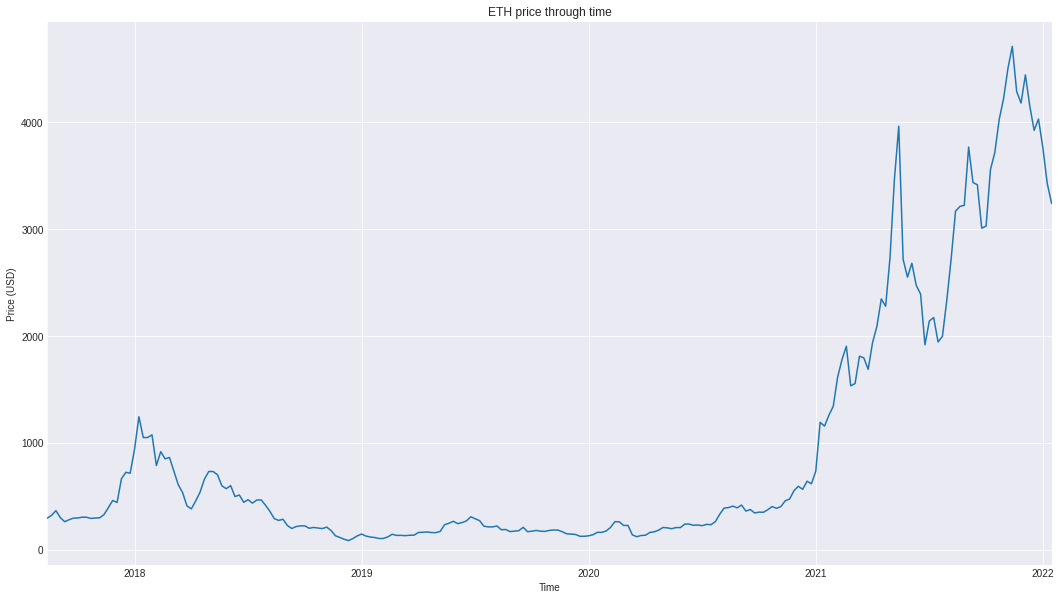

In [28]:
# Plot closing price through time
eth_week.close.plot(title='ETH price through time',
                                      xlabel='Time', ylabel='Price (USD)', figsize=[18,10])
plt.show()

###**4.3.2 ETH Volume through Time**

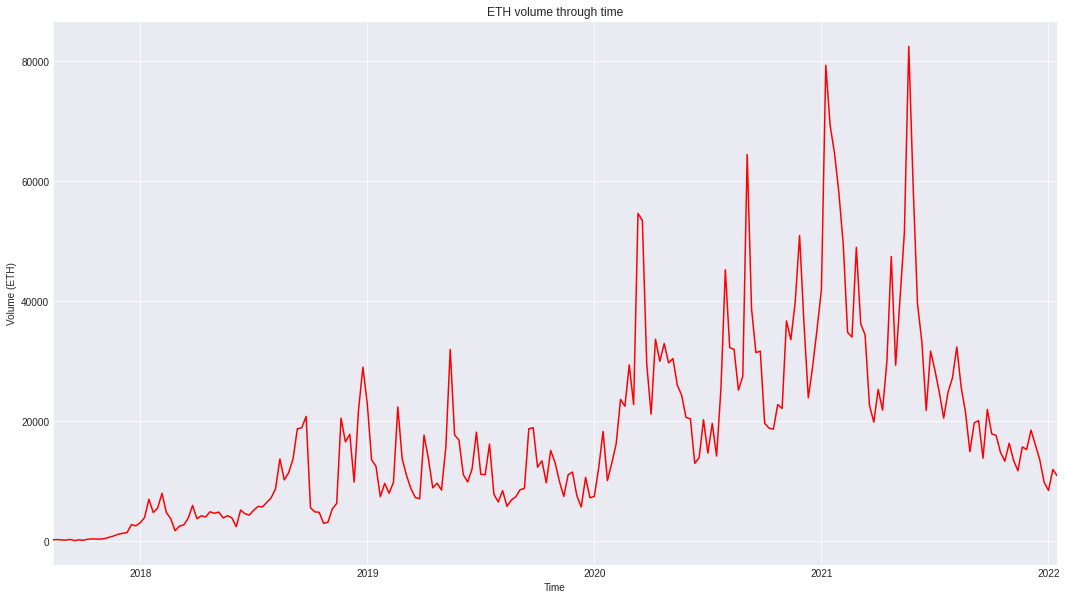

In [34]:
# Plot volume through time
eth_week['Volume ETH'].plot(title='ETH volume through time',
                                      xlabel='Time', ylabel='Volume (ETH)', color='red', figsize=[18,10])
plt.show()

###**4.3.3 Closing ETH Price in 2021 by Day, Month and Year**

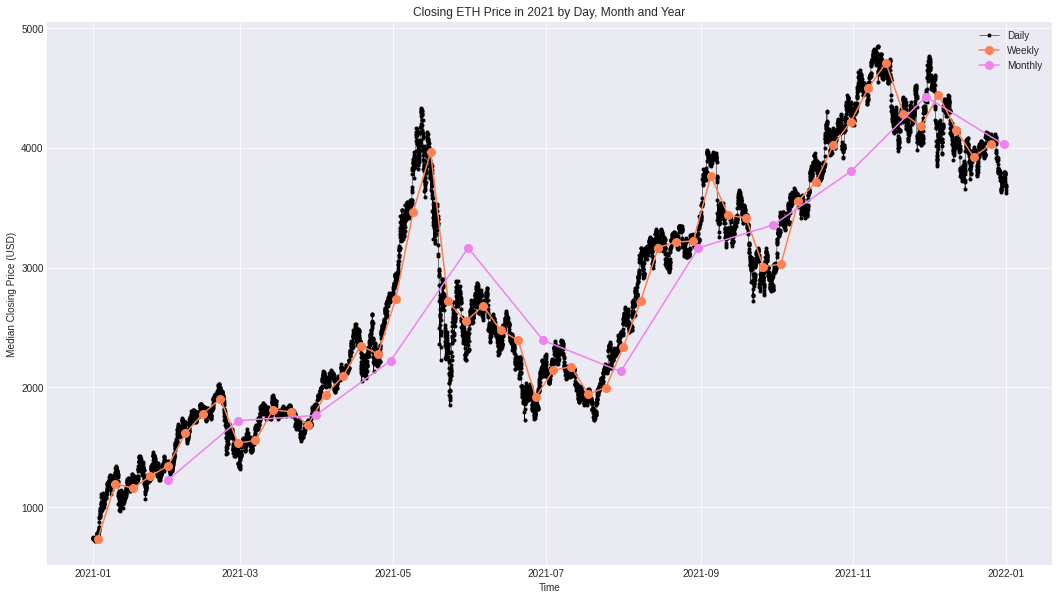

In [36]:
# Set dates as 2021
start, end = '2021-01', '2021-12'
# Plot three frequencies (daily, weekly, and monthly basis)
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(eth.loc[start:end, 'close'], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
ax.plot(eth_week.loc[start:end, 'close'], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral')
ax.plot(eth_month.loc[start:end, 'close'], marker='o', markersize=8, linestyle='-', label='Monthly', color='violet')
ax.set_title('Closing ETH Price in 2021 by Day, Month and Year')
ax.set_xlabel('Time')
ax.set_ylabel('Median Closing Price (USD)')
ax.legend()

###**4.3.4 ETH Opening Price Heatmap**

In [47]:
import calendar
# Create pivot table of eth opening price
all_month_year_df = pd.pivot_table(eth, values="open",
                                   index=eth.index.month,
                                   columns=eth.index.year
)
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]] # name months
all_month_year_df = all_month_year_df.set_index(named_index)
all_month_year_df

date,2017,2018,2019,2020,2021,2022
Jan,NaN,1083.194772,126.476022,155.238669,1187.572097,3424.603561
Feb,NaN,872.243006,125.855357,237.871351,1693.455097,NaN
Mar,NaN,630.046452,135.968925,161.983750,1722.294253,NaN
Apr,NaN,515.831181,164.735028,170.183028,2272.364601,NaN
May,NaN,677.711465,217.775914,206.979368,3145.557097,NaN
Jun,NaN,520.050597,273.942181,235.639819,2334.940778,NaN
Jul,NaN,462.191478,248.382836,256.679704,2121.645323,NaN
Aug,328.957163,323.040538,199.945753,399.952294,3077.480216,NaN
Sep,294.786494,227.111778,184.923875,369.084437,3347.006379,NaN
Oct,305.443132,211.951774,177.971169,375.485780,3796.526505,NaN


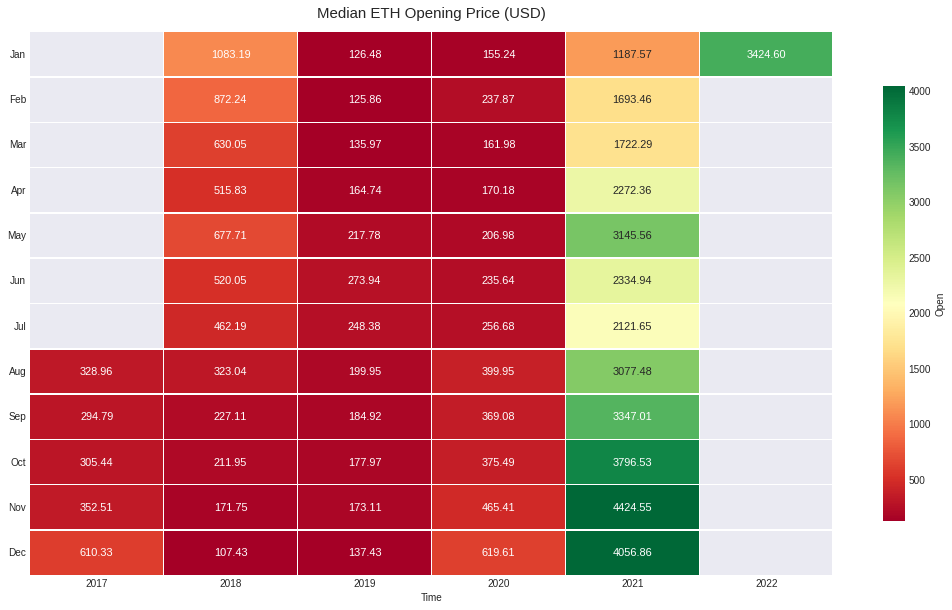

In [56]:
plt.figure(figsize=[18,10])
# Plot the heatmap
ax = sns.heatmap(all_month_year_df, cmap='RdYlGn', robust=True, fmt='.2f', 
                 annot=True, linewidths=.5, annot_kws={'size':11}, 
                 cbar_kws={'shrink':.8, 'label':'Open'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Median ETH Opening Price (USD)', fontdict={'fontsize':15},    pad=14)
plt.xlabel('Time')
plt.show()

###**4.3.5 Plotting the Change**

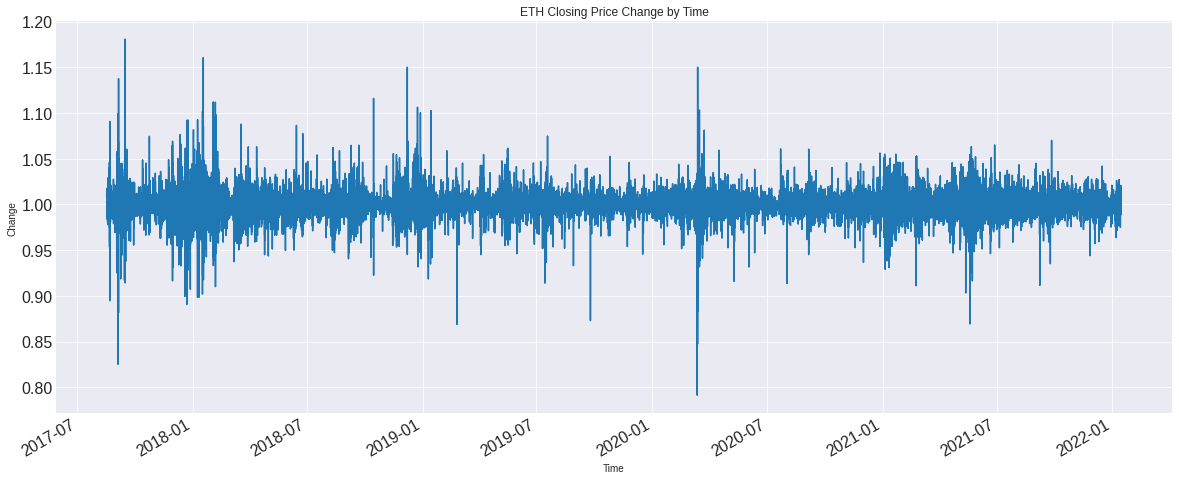

In [38]:
# Make copy of original eth dataset
vis_df = eth.copy()
# Adding change column in new dateset using shift
vis_df['change'] = vis_df.close.div(vis_df.close.shift())
# Plotting the change
vis_df['change'].plot(figsize=(20, 8), fontsize = 16)
plt.xlabel('Time')
plt.ylabel('Change')
plt.title('ETH Closing Price Change by Time')
plt.show()

###**4.3.6 Plotting the Percentage Change**

In [41]:
# Resample new viz dataset by month
vis_month = vis_df.resample('M').median()
# Calculate percentage change in new column
vis_month['pct_change'] = vis_month.close.pct_change()*100

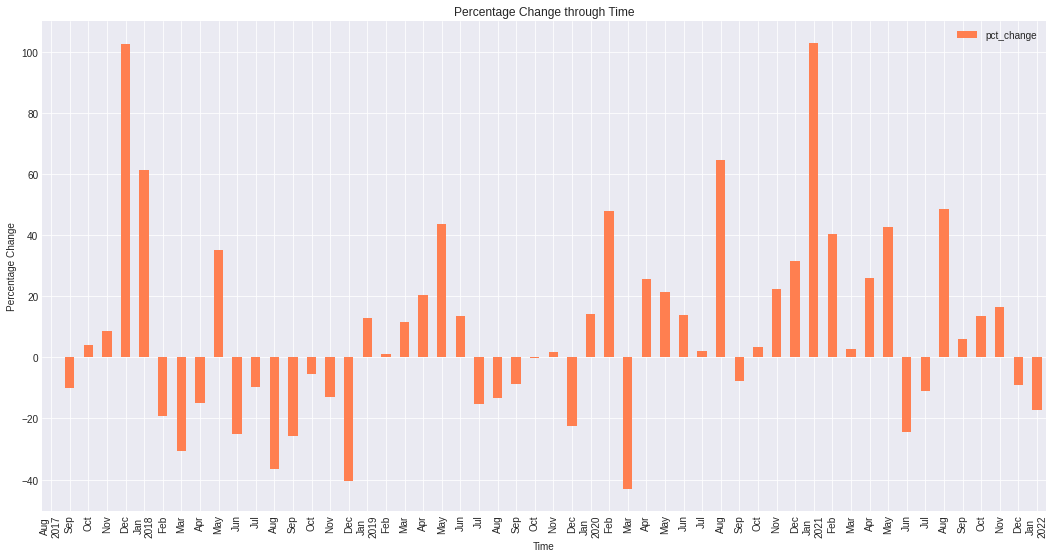

In [44]:
fig, ax = plt.subplots(figsize=(18, 10))
# Plot percentage change
vis_month['pct_change'].plot(kind='bar', color='coral', ax=ax)
# Set major ticks and tick labels
ax.set_xticks(range(vis_month.index.size))
ax.set_xticklabels([ts.strftime('%b\n%Y') if ts.year != vis_month.index[idx-1].year
                    else ts.strftime('%b') for idx, ts in enumerate(vis_month.index)])
ax.figure.autofmt_xdate(rotation=0, ha='center');
ax.set(xlabel='Time',
       ylabel='Percentage Change',
       title='Percentage Change through Time')
plt.xticks(rotation=90)
ax.legend()

###**4.3.7 Plotting the Decomposition**

<Figure size 1296x720 with 0 Axes>

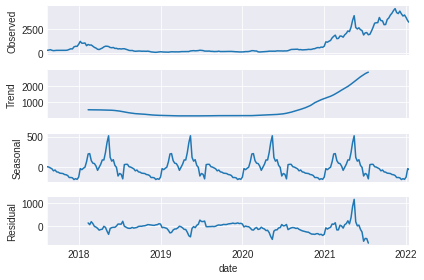

In [59]:
# Plot decomposition using statsmodel api
plt.figure(figsize=[18,10])
sm.tsa.seasonal_decompose(eth.resample("W").median().close).plot()
plt.show()

In [60]:
# Add log to closing price
eth["close_log"] = np.log1p(eth.close)
eth.head()

,open,high,low,close,Volume ETH,Volume USDT,close_log
date,,,,,,,
2017-08-17 04:00:00,652.74,652.74,298.0,300.79,122.52,36736.84,5.709731
2017-08-17 05:00:00,301.61,303.28,300.0,303.10,377.67,114043.28,5.717357
2017-08-17 06:00:00,303.10,304.44,301.9,302.68,302.51,91622.68,5.715975
2017-08-17 07:00:00,302.68,307.96,302.6,307.96,753.19,229248.31,5.733212
2017-08-17 08:00:00,307.96,309.97,307.0,308.62,150.75,46559.46,5.735346


<Figure size 1296x720 with 0 Axes>

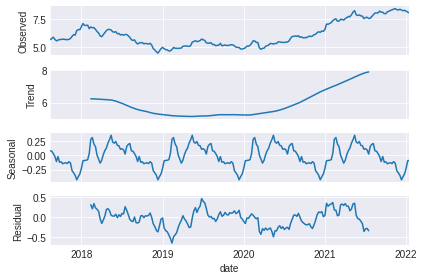

In [61]:
plt.figure(figsize=[18,10])
sm.tsa.seasonal_decompose(eth.resample("W").median().close_log).plot()
plt.show()

#**5 Statistical Tests**

## **5.1 Dickey-Fuller-Test**

In [62]:
dickey = sm.tsa.stattools.adfuller(eth.resample("W").mean().close)

print(f'ADF Statistic: {dickey[0]:.2f}')
print(f'p-value: {dickey[1]:.2f}')
print('Critical Values:')
for key, value in dickey[4].items():
        print(f'\t {key}: {value:.3f}')

ADF Statistic: 1.04
p-value: 0.99
Critical Values:
	 1%: -3.460
	 5%: -2.875
	 10%: -2.574


In [63]:
dickey = sm.tsa.stattools.adfuller(eth.resample("W").mean().close_log)

print(f'ADF Statistic: {dickey[0]:.2f}')
print(f'p-value: {dickey[1]:.2f}')
print('Critical Values:')
for key, value in dickey[4].items():
        print(f'\t {key}: {value:.3f}')

ADF Statistic: -0.48
p-value: 0.90
Critical Values:
	 1%: -3.459
	 5%: -2.874
	 10%: -2.574


# **6. Feature Engineering**

In [64]:
# Create main set to train and validate
eth_main = eth.loc['2017-08-17':'2021-10-15']
eth_main.shape

(39127, 7)

In [65]:
eth_main.tail()

,open,high,low,close,Volume ETH,Volume USDT,close_log
date,,,,,,,
2021-10-15 19:00:00,3879.97,3882.99,3836.10,3848.90,14561.6656,5.614232e+07,8.255802
2021-10-15 20:00:00,3848.91,3907.77,3833.00,3881.36,35909.0981,1.391489e+08,8.264198
2021-10-15 21:00:00,3881.37,3884.63,3820.87,3841.40,14950.9961,5.766778e+07,8.253852
2021-10-15 22:00:00,3841.41,3857.73,3832.15,3849.76,12072.0272,4.640737e+07,8.256026
2021-10-15 23:00:00,3849.77,3874.00,3839.55,3868.99,12247.8107,4.723873e+07,8.261007


In [67]:
# Create holdout set
eth_recent = eth.loc['2021-10-16':]
eth_recent.shape

(2185, 7)

In [68]:
eth_recent.tail()

,open,high,low,close,Volume ETH,Volume USDT,close_log
date,,,,,,,
2022-01-14 20:00:00,3308.01,3317.79,3297.86,3303.18,9984.7476,3.300588e+07,8.102944
2022-01-14 21:00:00,3303.18,3342.79,3302.02,3331.04,8602.0015,2.854450e+07,8.111340
2022-01-14 22:00:00,3331.04,3332.69,3313.22,3313.49,6819.0635,2.266250e+07,8.106059
2022-01-14 23:00:00,3313.49,3318.70,3293.13,3307.42,7636.2628,2.525621e+07,8.104226
2022-01-15 00:00:00,3307.42,3325.68,3307.22,3311.03,3469.7092,1.150450e+07,8.105317


In [69]:
# Preparing dataset
split = int(eth_main.shape[0]*0.8)
df_train = eth_main[:split]
df_test = eth_main[split:]
df_test.head()

,open,high,low,close,Volume ETH,Volume USDT,close_log
date,,,,,,,
2020-11-23 04:00:00,573.79,586.38,572.01,581.86,114260.59470,6.640364e+07,6.367947
2020-11-23 05:00:00,581.87,584.50,576.89,580.47,61895.54053,3.595897e+07,6.365559
2020-11-23 06:00:00,580.45,586.34,573.80,586.23,91132.98601,5.274432e+07,6.375417
2020-11-23 07:00:00,586.24,587.73,578.50,580.85,59752.97685,3.478342e+07,6.366213
2020-11-23 08:00:00,580.94,587.12,580.89,582.41,69081.16781,4.036242e+07,6.368890


In [79]:
# Write a function to generate desired dataset
def create_dataset(df, n, feature=-1):
   """Create proper dataset for supervised time series forcasting.

   Args:
   df: input dataframe
   n: number of values to consider in a window as features
   feature: chosen column (feature) to perform
   
   Return:
   x, y = returns x as features and y as target variable
   """
   x = []
   y = []

   for i in range(n, df.shape[0]):
     x.append(df[i-n:i, feature])
     y.append(df[i, feature])
   x = np.expand_dims(np.array(x), -1)
   y = np.expand_dims(np.array(y), -1)  
   return x, y

In [80]:
# Scale before modeling
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(df_train)
dataset_train[0:5]

array([[4.23007918e-01, 4.19873991e-01, 1.64544631e-01, 1.62080009e-01,
        2.64602411e-04, 2.21182018e-04, 4.52870142e-01],
       [1.62687939e-01, 1.62359530e-01, 1.66066713e-01, 1.63792592e-01,
        8.15641467e-04, 6.86622008e-04, 4.55549455e-01],
       [1.63792592e-01, 1.63214325e-01, 1.67512690e-01, 1.63481213e-01,
        6.53320889e-04, 5.51633980e-04, 4.55063824e-01],
       [1.63481213e-01, 1.65808187e-01, 1.68045419e-01, 1.67395688e-01,
        1.62663965e-03, 1.38023858e-03, 4.61120613e-01],
       [1.67395688e-01, 1.67289341e-01, 1.71393998e-01, 1.67884997e-01,
        3.25569813e-04, 2.80321207e-04, 4.61870423e-01]])

In [81]:
# Scale validation set
dataset_test = scaler.transform(df_test)

In [82]:
# Create train and test sets using our function
X_train, y_train = create_dataset(dataset_train,50,-1)
X_test, y_test = create_dataset(dataset_test,50,-1)

In [83]:
# Check if it worked!
X_train.shape

(31251, 50, 1)

In [84]:
y_train.shape

(31251, 1)

# **7. Evaluation Function**

In [85]:
def evaluate_model(model, model_name="Model", test_data=X_test, target_data=y_test):
    """ Create an evaluation function and plot the result.
    Args:
        model: selected model that has been used
        model_name: label to plot
        test_data: validation set of features
        target_data: validation set of target
    
    Returns:
        test_rs: R-squared value of test set
        test_MAE: mean absolute error of test set
    
    """
    y_pred_test = model.predict(test_data)

    try:
        y_pred_test = y_pred_test.yhat 
    except:
        pass

    test_rs = r2_score(target_data,y_pred_test)
    print('R Squared : ', round(test_rs,5))

    test_MAE = mean_absolute_error(target_data, y_pred_test)
    print('Mean Absolute Error: ', round(test_MAE, 5))

    plt.figure(figsize=(20,10))
    plt.plot(y_pred_test, color='green', marker='o', linestyle='dashed',label='Predicted Price')
    plt.plot(target_data, color='red', label='Actual Price')
    plt.title('Comparison of actual and predicted ETH-USD price for ' + model_name)
    plt.xlabel('Day')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()
    
    return test_rs, test_MAE

# **8. Models**

## **8.1 XGBOOST**

In [ ]:
# Instantiate an xgboost regressor object
xgb_model = xgboost.XGBRegressor()
# Fit the training date
xgb_model.fit(np.squeeze(X_train), np.squeeze(y_train))

[15:19:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

R Squared :  -0.24712
Mean Absolute Error:  0.16946


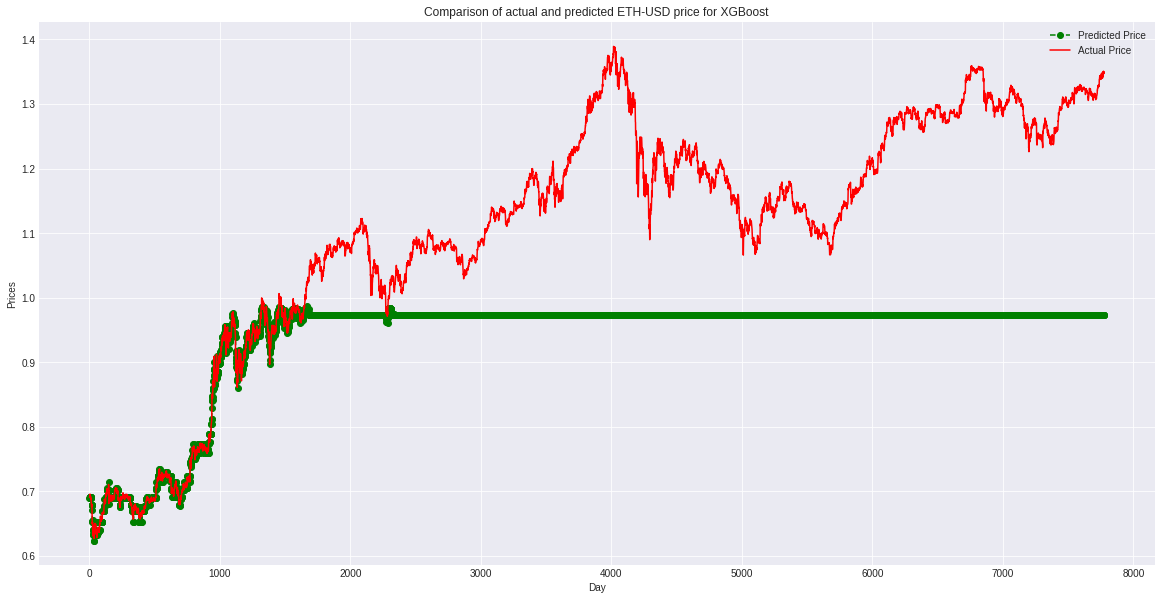

(-0.24712354152634952, 0.1694612214239119)

In [ ]:
# Evaluate the results
evaluate_model(xgb_model, model_name="XGBoost", test_data=np.squeeze(X_test), target_data=np.squeeze(y_test))

## **8.2 LSTM**

In [ ]:
# Instantiate sequential model
LSTM_Model = Sequential()

In [ ]:
# Define lstm model
LSTM_Model.add(LSTM(units=96,
                    return_sequences=True,
                    input_shape=(X_train.shape[1], 1)))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(LSTM(units=96, 
                    return_sequences=True))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(LSTM(units=96, 
                    return_sequences=True))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(LSTM(units=96))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(Dense(units=1))

In [ ]:
# Config the model
LSTM_Model.compile(loss=MSE, optimizer=Adam())

In [ ]:
# Summary of model
LSTM_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_2 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

In [ ]:
# Fit the model
LSTM_Model.fit(X_train,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.05)

Epoch 1/10
928/928 [==============================] - 171s 175ms/step - loss: 0.0019 - val_loss: 3.8098e-05
Epoch 2/10
928/928 [==============================] - 160s 172ms/step - loss: 7.7924e-04 - val_loss: 1.6556e-04
Epoch 3/10
928/928 [==============================] - 160s 173ms/step - loss: 5.8199e-04 - val_loss: 1.7027e-04
Epoch 4/10
928/928 [==============================] - 161s 173ms/step - loss: 4.9229e-04 - val_loss: 2.0444e-05
Epoch 5/10
928/928 [==============================] - 161s 174ms/step - loss: 4.0613e-04 - val_loss: 3.0678e-05
Epoch 6/10
928/928 [==============================] - 161s 174ms/step - loss: 3.3736e-04 - val_loss: 2.9407e-05
Epoch 7/10
928/928 [==============================] - 160s 172ms/step - loss: 3.3257e-04 - val_loss: 9.3393e-05
Epoch 8/10
928/928 [==============================] - 161s 174ms/step - loss: 3.1345e-04 - val_loss: 2.1270e-05
Epoch 9/10
928/928 [==============================] - 159s 171ms/step - loss: 3.1050e-04 - val_loss: 7.2847e

R Squared :  0.94283
Mean Absolute Error:  0.0341


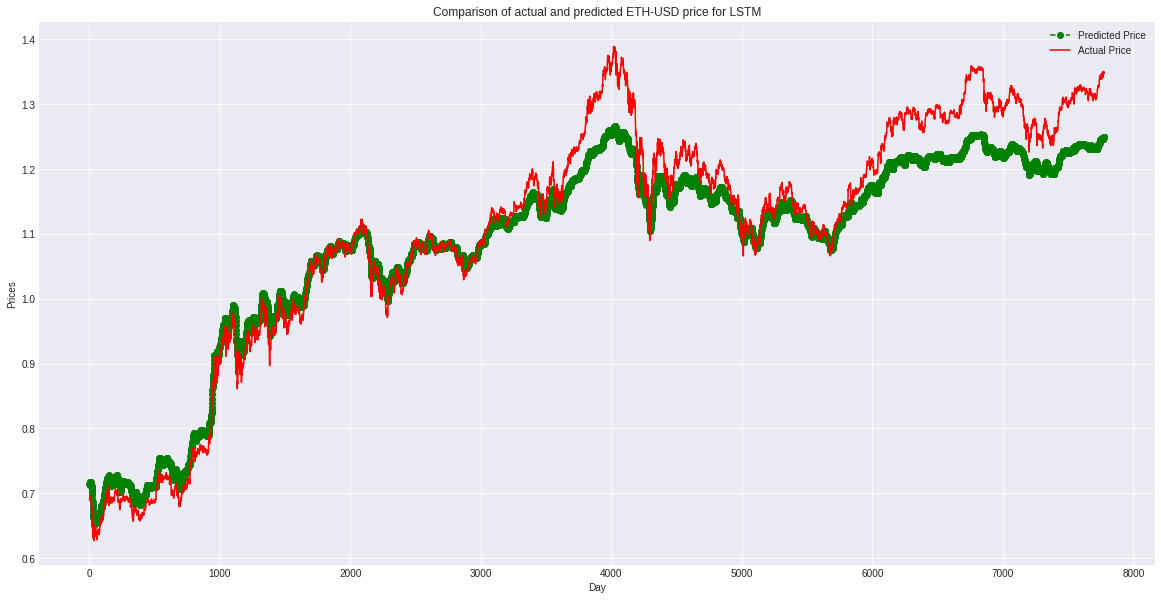

(0.9428281219948325, 0.03410051393472604)

In [ ]:
# Evaluate the model and plot the results
evaluate_model(LSTM_Model, "LSTM")

## **8.3 CNN**

In [ ]:
# Instantiate sequential model
CNN_model=Sequential()

In [ ]:
# Define cnn model
CNN_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train[0].shape))
CNN_model.add(MaxPooling1D(3))
CNN_model.add(Dropout(0.1))
CNN_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
CNN_model.add(MaxPooling1D(3))
CNN_model.add(Dropout(0.1))
CNN_model.add(Flatten())
CNN_model.add(Dense(32, activation='relu'))
CNN_model.add(Dense(1, activation='relu'))

In [ ]:
# Config the model
CNN_model.compile(optimizer='adam', loss='mse')

In [ ]:
# Summary of model
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 32)           0         
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 16, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 4, 64)            

In [ ]:
# Fit the model
CNN_model.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20
879/879 [==============================] - 6s 6ms/step - loss: 0.0015 - val_loss: 0.0109
Epoch 2/20
879/879 [==============================] - 5s 6ms/step - loss: 5.2011e-04 - val_loss: 0.0069
Epoch 3/20
879/879 [==============================] - 5s 6ms/step - loss: 4.6680e-04 - val_loss: 0.0031
Epoch 4/20
879/879 [==============================] - 5s 6ms/step - loss: 4.0098e-04 - val_loss: 0.0031
Epoch 5/20
879/879 [==============================] - 5s 6ms/step - loss: 3.7627e-04 - val_loss: 0.0034
Epoch 6/20
879/879 [==============================] - 5s 5ms/step - loss: 3.4396e-04 - val_loss: 0.0017
Epoch 7/20
879/879 [==============================] - 5s 5ms/step - loss: 3.3707e-04 - val_loss: 0.0035
Epoch 8/20
879/879 [==============================] - 5s 6ms/step - loss: 3.2449e-04 - val_loss: 0.0017
Epoch 9/20
879/879 [==============================] - 5s 6ms/step - loss: 3.2047e-04 - val_loss: 4.1846e-04
Epoch 10/20
879/879 [==============================] - 5s 6ms/st

R Squared :  0.7042
Mean Absolute Error:  0.09652


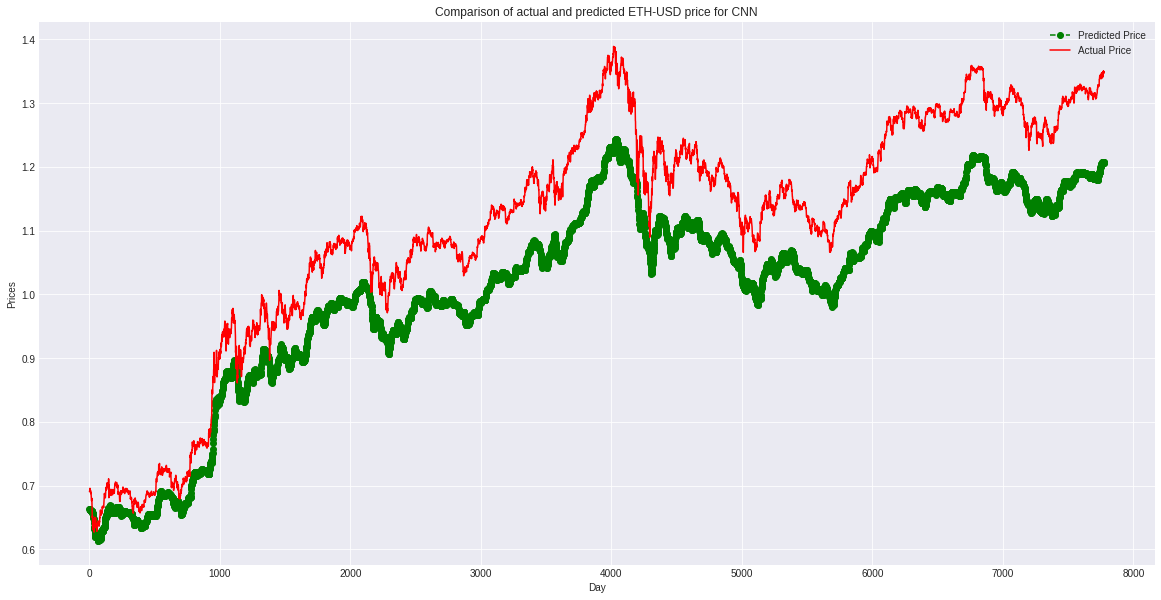

(0.7041962606124348, 0.09652407555324777)

In [ ]:
# Evaluate the model and plot the results
evaluate_model(CNN_model, "CNN")

In [ ]:
# Save models
# LSTM_Model.save('LSTM.h5')
# CNN_model.save('CNN.h5')

# **9. Deploy Model into Recent Data**

In [ ]:
# Reminder on recent data which contains three months of eth price
eth_recent.head()

,open,high,low,close,Volume ETH,Volume USDT,close_log
date,,,,,,,
2021-10-16 00:00:00,3868.38,3872.98,3838.98,3844.83,11349.8454,4.375050e+07,8.254745
2021-10-16 01:00:00,3844.84,3854.95,3823.04,3836.19,10986.7950,4.217460e+07,8.252496
2021-10-16 02:00:00,3836.18,3854.78,3823.81,3853.31,11101.0012,4.260368e+07,8.256947
2021-10-16 03:00:00,3853.31,3853.31,3833.00,3842.95,7793.7926,2.996249e+07,8.254256
2021-10-16 04:00:00,3842.95,3867.82,3834.66,3834.66,12265.4954,4.720833e+07,8.252097


In [ ]:
# Scale before model
scaled_recent = scaler.fit_transform(eth_recent)

In [ ]:
# Generate a new dataset out of recent data
X_test2, y_test2 = create_dataset(scaled_recent, 50, -1)

In [ ]:
# Check the shape
X_test2.shape

(2135, 50, 1)

R Squared :  0.97373
Mean Absolute Error:  0.02647


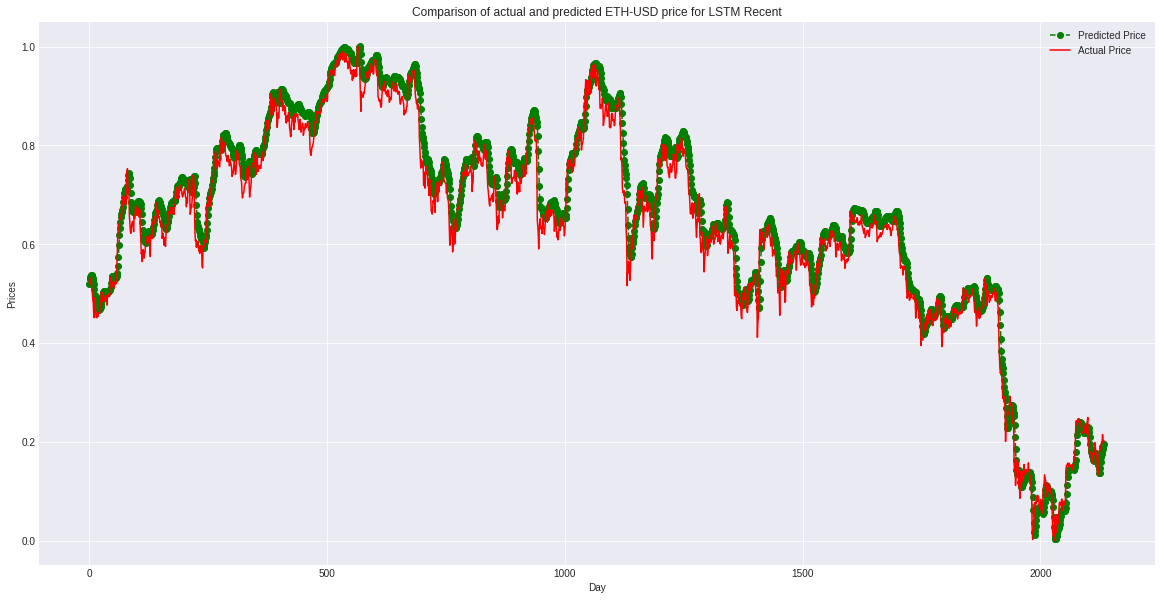

(0.9737313599198155, 0.026472181341884726)

In [ ]:
# Evaluate the performance of model on recent data and plot the results
evaluate_model(LSTM_Model, "LSTM Recent", X_test2, y_test2)

# **10. Conclusions**

In [86]:
result = {'Model': ['XGBOOST', 'LSTM', 'CNN'], 
          'R-squared': [-0.247, 0.942, 0.704], 'MAE':[0.169, 0.034, 0.096]}

In [95]:
df_result = pd.DataFrame(result)
df_result.set_index('Model', inplace=True)
df_result

,R-squared,MAE
Model,,
XGBOOST,-0.247,0.169
LSTM,0.942,0.034
CNN,0.704,0.096
